<a href="https://colab.research.google.com/github/vbncml/explore_pinns/blob/main/PINN_final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bridging Physics and Machine Learning: Experiments with Physics-Informed Neural Networks

**Author**: Gaukhar Nurbek  
**Date**: December 2024  

---

## Introduction

Physics-informed neural networks (PINNs) are function approximators designed to incorporate knowledge of physical laws into the learning process . These physical laws, often described by partial differential equations (PDEs), serve as a form of regularization during training, constraining the solution space and improving the accuracy of function approximation. PINNs are particularly effective in scenarios where data availability is limited, such as in certain biological, physical and engineering systems, where traditional machine learning approaches often struggle to perform robustly. By embedding prior knowledge of physical principles, PINNs enhance the information content of the available data, enabling the model to learn the correct solution and generalize effectively, even with a small number of training examples [1].

This report presents experiments conducted using PINNs for three different cases:
1. **Heat Distribution**: Modeling the diffusion of heat in one dimensional system.
2. **Schrödinger Equation**: Simulating quantum mechanical wave function.
3. **Wave Equation**: Analyzing wave propagation in physical systems.

Through these case studies, this work aims to evaluate the performance, accuracy, and limitations of PINNs in solving diverse physical problems. The experiments highlight the potential of PINNs to provide interpretable and accurate solutions.

The remainder of this report is organized as follows:
- Section 1 provides an overview of the PINN framework.
- Sections 2, 3, 4 describe the setup and results for each experiment.
- Section 5 discusses the findings and potential improvements.
- Finally, Section 6 concludes the report.



## 1. Physics-Informed Neural Networks (PINNs)


**What are PINNs?**  
Physics-Informed Neural Networks are a class of machine learning models that integrate physical laws directly into their training process. Unlike traditional neural networks, PINNs embed governing equations such as PDEs into the loss function, enabling the model to simultaneously minimize data-based errors and satisfy physical constraints.

From a **Computer Science (CS)** perspective, PINNs are built on three core concepts:
- **Universal Approximation**: Neural networks can approximate complex functions.
- **Loss Functions**: PINNs incorporate physical laws (e.g., PDEs) directly into the loss function as a penalty term. Such as following:
$Loss_{PINN} = Loss_{data} + Loss_{physics}$\
$Loss_{data} = \frac{1}{N}\sum_j^N{\left\lVert f(x_j|\theta) - y_j \right\rVert_2^2}$ \
$Loss_{physics} = \lambda\frac{1}{M}\sum_i^M{\left\lVert g(x_i, f(x_i|\theta)) \right\rVert_2^2}$ \
Here $g(x,y)$ is a differential equation, ${x_j,y_j}$ is our data, ${x_i}$ are collocation points, $f(x|\theta)$ is a neural network and $\lambda$ is a parameter that controls the strength of physics loss.
- **Autodifferentiation**: PINNs leverage automatic differentiation to compute derivatives efficiently, essential for embedding PDEs.

Applications include solving forward problems (e.g., simulation of physical processes) and inverse problems (e.g., parameter estimation).
The experiments in this report involve defining a neural network, generating training and testing datasets based on a given equation, specifying a physics-informed loss function, training the network, and visualizing the predictions. The next section provides a detailed exploration of using PINNs to simulate the cooling process of coffee.

## 2. Heat Distribution

This section focuses on modeling heat diffusion in a cooling coffee cup based on the tutorial from [3]. The problem is governed by the **heat equation**:\
$
\frac{\partial T(t)}{\partial t} = r(T_{env} - T(t))
$\
where $T(t)$ is a temperature, $r$ is a cooling rate, and $T_{env}$ is a temperature of the environment. \
In this experiment colling down of the hot boiling coffee in the 25 degree Celcius enviromens and a cooling rate of 0.005 was modeled. Firstly, a neural network architecture was defined, after that the data with given boundary conditions was simulated and first 10 data points were collected as training dataset. First vanilla neural network was trained and after that physical loss function was defined to train PINNs. The code and correspoding figures for these steps are provided below.

### Neural Network Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)


class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()

### Data generation and collection

In [ ]:
import torch
import numpy as np
import seaborn as sns
import functools
import matplotlib.pyplot as plt

def grad(outputs, inputs):
    """Computes the partial derivative of
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

np.random.seed(10)

Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

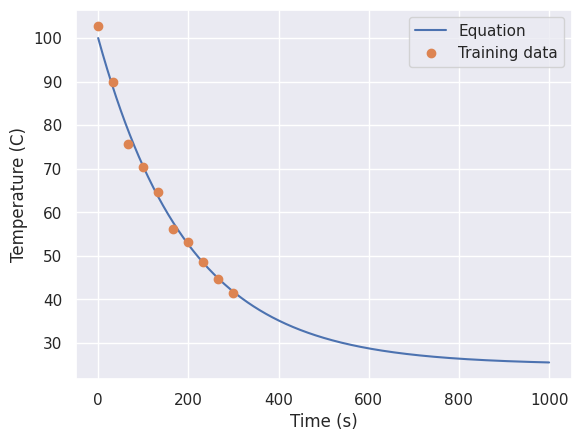

### Vanilla Neural Network training

In [ ]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

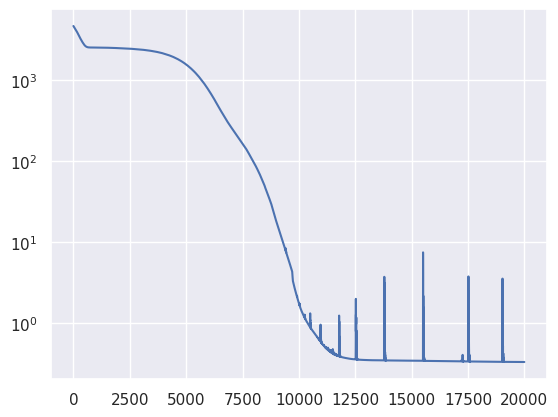

In [ ]:
preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

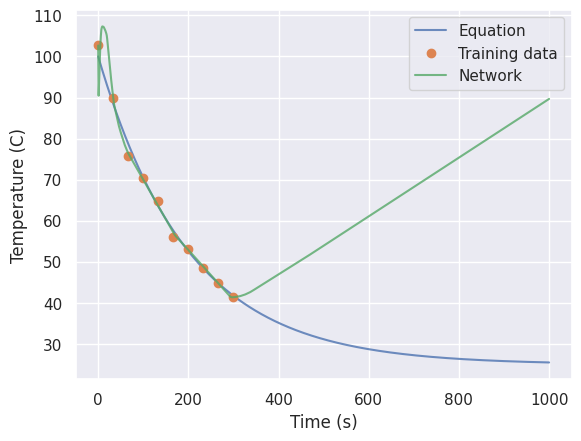

### PINNs training

In [ ]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT

    return torch.mean(pde**2)

net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

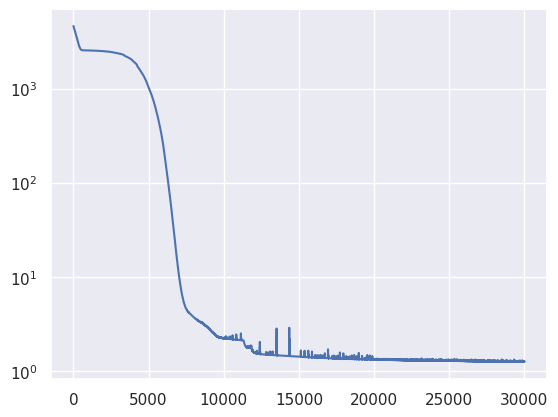

In [ ]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

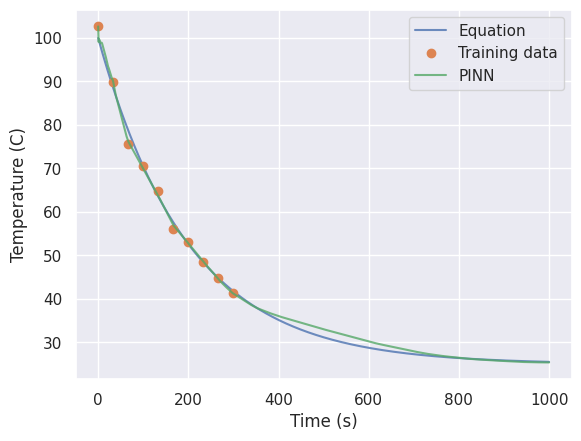

The prediction plots demonstrate that the PINN outperforms a standard vanilla neural network when provided with a limited dataset for modeling the cooling process.

### Collab Notebook
[Temperature prediction](https://colab.research.google.com/drive/1WiaMoF_V_Gn1UOHuPECXhW6ItLgee96E?usp=sharing)

## 3. Schrödinger Equation

In this section, the recently published PINNs-TF2 [2] library was utilized to solve the Schrödinger Equation based on tutorial from [4]. Built on TensorFlow V2, this Python library simplifies the implementation of PINNs. The spatial and temporal domains were defined using specified intervals, followed by generating a mesh over these intervals. A neural network was then constructed with four hidden layers, each containing 100 neurons. The network took  $x$  and  $t$  as inputs and produced  $u(x,t)$  and  $v(x,t)$  as outputs. The Schrödinger Equation used in this setup is as follows: \
$$f_u = u_t + 0.5v_{xx} + v(u^2+v^2)$, $f_v = v_t + 0.5u_{xx} + u(u^2+v^2)$$ \
Initial conditions were specified as: \
$$u(0,x) = 2sech(x), v(0,x) = 0$$
Using these equations and initial conditions, a training dataset was generated to train the PINN. The corresponding code and a visualization of the results are provided below.

In [ ]:
!pip install pinnstf2

#### Import Libraries

from typing import Dict

import tensorflow as tf
import numpy as np

import pinnstf2

#Define Mesh with Separate Time and Spatial Domains

def read_data_fn(root_path):
    """Read and preprocess data from the specified root path.

    :param root_path: The root directory containing the data.
    :return: Processed data will be used in Mesh class.
    """

    data = pinnstf2.utils.load_data(root_path, "NLS.mat")
    exact = data["uu"]
    exact_u = np.real(exact) # N x T
    exact_v = np.imag(exact) # N x T
    exact_h = np.sqrt(exact_u**2 + exact_v**2) # N x T
    return {"u": exact_u, "v": exact_v, "h": exact_h}

# Now, define the time and spatial domains for mesh generation. The choice of these parameters depends on the specific problem being solved and should be set accordingly.

time_domain = pinnstf2.data.TimeDomain(t_interval=[0, 1.57079633], t_points = 201)
spatial_domain = pinnstf2.data.Interval(x_interval= [-5, 4.9609375], shape = [256, 1])

mesh = pinnstf2.data.Mesh(root_dir='data',
                            read_data_fn=read_data_fn,
                            spatial_domain = spatial_domain,
                            time_domain = time_domain)

# Define Train datasets

# Set number of samples

N0 = 50

# Define Initial Condition
def initial_fun(x):
    return {'u': 2*1/np.cosh(x), 'v': np.zeros_like(x)}

in_c = pinnstf2.data.InitialCondition(mesh = mesh,
                                        num_sample = N0,
                                        initial_fun = initial_fun,
                                        solution = ['u', 'v'])

# Define Periodic Boundary Condition

N_b = 50
pe_b = pinnstf2.data.PeriodicBoundaryCondition(mesh = mesh,
                                                 num_sample = 50,
                                                 derivative_order = 1,
                                                 solution = ['u', 'v'])

# Mesh Sampler for collection points and solutions

N_f = 20000
me_s = pinnstf2.data.MeshSampler(mesh = mesh,
                                   num_sample = N_f,
                                   collection_points = ['f_v', 'f_u'])

# Define Validation dataset

val_s = pinnstf2.data.MeshSampler(mesh = mesh,
                                    solution = ['u', 'v', 'h'])
# Define Neural Networks

net = pinnstf2.models.FCN(layers = [2, 100, 100, 100, 100, 2],
                            output_names = ['u', 'v'],
                            lb=mesh.lb,
                            ub=mesh.ub)

# Define `pde_fn` and `output_fn` functions
"""
- `output_fn`: is applied to the network's output, adding any necessary post-processing computations. For example, in our case, `h(x,t) = u(x,t)**2 + v(x,t)**2`, thus, we define this equation in `output_fn`.
- `pde_fn`: formulates the PDE constraints, which will be used by the `MeshSampler` to compute the loss at the collection points.

"""
def output_fn(outputs: Dict[str, tf.Tensor],
              x: tf.Tensor,
              t: tf.Tensor):

    outputs["h"] = tf.sqrt(outputs["u"] ** 2 + outputs["v"] ** 2)

    return outputs

def pde_fn(outputs: Dict[str, tf.Tensor],
           x: tf.Tensor,
           t: tf.Tensor)

    u_x, u_t = pinnstf2.utils.gradient(outputs["u"], [x, t])
    v_x, v_t = pinnstf2.utils.gradient(outputs["v"], [x, t])

    u_xx = pinnstf2.utils.gradient(u_x, x)[0]
    v_xx = pinnstf2.utils.gradient(v_x, x)[0]

    outputs["f_u"] = u_t + 0.5 * v_xx + (outputs["u"] ** 2 + outputs["v"] ** 2) * outputs["v"]
    outputs["f_v"] = v_t - 0.5 * u_xx - (outputs["u"] ** 2 + outputs["v"] ** 2) * outputs["u"]

    return outputs

# Define PINNDataModule and PINNModule
"""
- `PINNDataModule` manages data.
- `PINNModule` handles the model, compilation, and various enhancements like AMP.
"""

train_datasets = [me_s, in_c, pe_b]
val_dataset = val_s
datamodule = pinnstf2.data.PINNDataModule(train_datasets = [me_s, in_c, pe_b],
                                            val_dataset = val_dataset,
                                            pred_dataset = val_s)

model = pinnstf2.models.PINNModule(net = net,
                                   pde_fn = pde_fn,
                                   output_fn = output_fn,
                                   loss_fn = 'mse')

# Setting Up the Trainer
trainer = pinnstf2.Trainer(max_epochs=15000, check_val_every_n_epoch=1000)

# Training
trainer.fit(model=model, datamodule=datamodule)

# Validation
trainer.validate(model=model, datamodule=datamodule)

# Visualization
preds_dict = trainer.predict(model=model, datamodule=datamodule)
pinnstf2.utils.plot_schrodinger(mesh=mesh,
                                preds=preds_dict,
                                train_datasets=train_datasets,
                                val_dataset=val_dataset,
                                file_name='out')



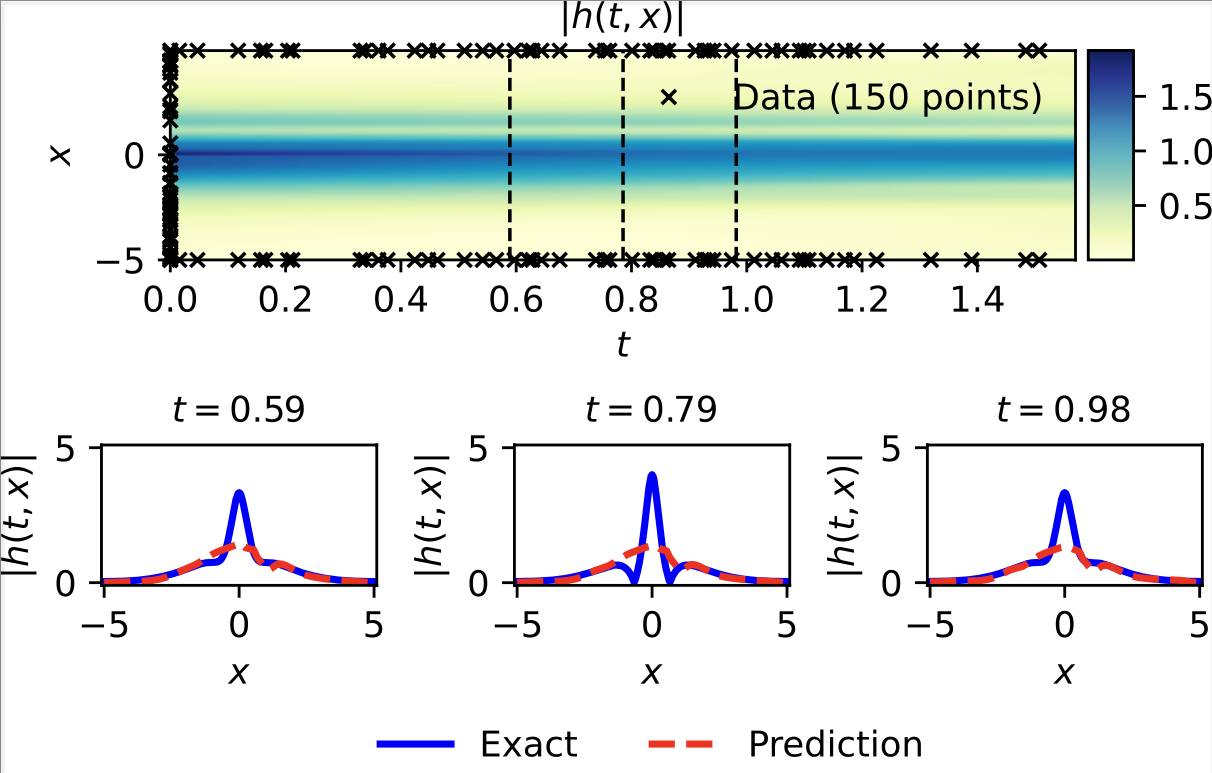

As shown in the figure above, PINNs for the Schrödinger equation perform well in predicting values near the boundaries but struggle to accurately predict values in the intermediate region.

## 4. Wave equation

In this section, PINNs are employed to solve the wave equation: \
$$
y(x, t) = \sin\left(\frac{\pi}{L} x\right) \cos\left(\frac{\pi}{L} c t \right)$$ The solution is evaluated using a physics-informed loss function that solves following PDE:
$$ \frac{\partial^2 y}{\partial t^2} = c^2 \frac{\partial^2 y}{\partial x^2} $$ An experiment was conducted to assess the impact of varying the architecture of PINNs, specifically focusing on the depth and width of the network. Results showed that while increasing the depth of the network does not necessarily improve performance, increasing the width enhances the predictive accuracy of the PINNs.

Similar to Section 2, a neural network architecture was defined, and data was simulated based on the given boundary conditions. A training dataset was created using sampled data points. Both a vanilla neural network and PINNs with varying architectures were trained and compared. The corresponding code and visualizations for these steps are provided below.

### Neural Network Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)


class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units = 100,  #32, 64, 128, 256
        n_hidden_layers = 3,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units
        self.n_hidden_layers = n_hidden_layers

        layers = []
        layers.append(nn.Linear(input_dim, self.n_units))
        layers.append(nn.ReLU())

        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(self.n_units, self.n_units))
            layers.append(nn.ReLU())

        self.layers = nn.Sequential(*layers)
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            # grad_norm = sum(p.grad.norm().item() for p in self.parameters() if p.grad is not None)
            # print(f"Epoch {ep}, Grad Norm: {grad_norm:.4f}")
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()

### Data generation, collection and visualization

In [ ]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns


def grad(outputs, inputs):
    """Computes the partial derivative of
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

def harmonic_wave(x, t, A, k, w, phi):
    """
    This function calculates the value of a harmonic wave at position x and time t.

    Parameters:
    x: Position (array or scalar)
    t: Time (scalar)
    A: Amplitude
    k: Wavenumber
    w: Angular frequency
    phi: Phase constant

    Returns:
    y: The value of the wave at position x and time t
    """
    y = A * np.sin(k * x) * np.cos(w * t + phi)

    return y

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

# Wave example

import numpy as np
import functools

# Parameters
A = 1.0           # Amplitude
L = 1.0           # Length of the string
c = 1.0           # Wave speed
n = 1             # Mode number (fundamental frequency)
phi = 0           # Phase shift
omega = n * np.pi * c / L           # Angular frequency
k = n * np.pi / L  # wave number

# Use functools.partial to fix all parameters except for time and position
wave_function = functools.partial(harmonic_wave, A=A, k=k, w=omega, phi=phi)

# Define x and t ranges
x = np.linspace(0, L, 500)          # Position array
t = np.linspace(0, 2, 200)          # Time array

# Evaluate the harmonic wave
X, T = np.meshgrid(x, t)
Y = wave_function(X, T)

test_data = np.stack([X.flatten(), T.flatten()], axis=-1)

# Make training data
np.random.seed(10)
# Overlaying sample points on the heatmap
x_train = np.linspace(0, L, 5)            # Sample x points
t_train = np.linspace(0, 1, 5)            # Sample t points
X_train, T_train = np.meshgrid(x_train, t_train)
Y_train = wave_function(X_train,T_train) +  0.01 * np.random.randn(5)

train_data = np.stack([X_train.flatten(), T_train.flatten()], axis=-1)

# Plotting
plt.figure(figsize=(12, 6))
plt.contourf(X, T, Y, 50, cmap='viridis')  # Heatmap of the wave amplitude
plt.colorbar(label="Displacement Amplitude (y)")
plt.xlabel("Position (x)")
plt.ylabel("Time (t)")
plt.title(f"Heatmap of Standing Wave on a String with Closed Boundaries (Mode {n})")


# Overlay points as stars or dots
plt.scatter(X_train, T_train, c=Y_train, cmap='viridis', edgecolor='white', s=100, marker='*')

plt.show()

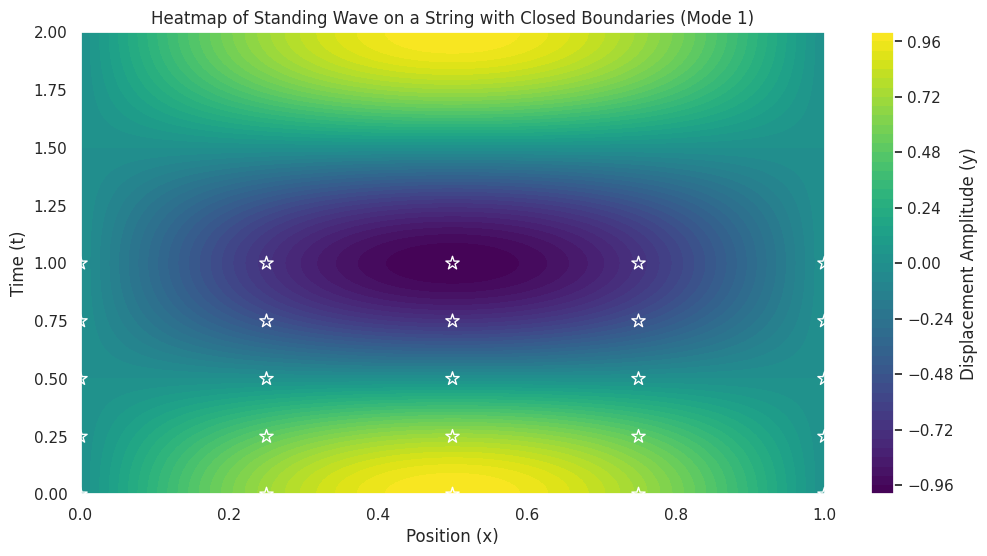

In [ ]:
# Plot
plt.figure(figsize=(12, 6))

# Use a colormap
cmap = plt.get_cmap("viridis")  # Choose a colormap (e.g., "viridis", "plasma", "cool", etc.)
colors = cmap(np.linspace(0, 1, len(range(1, len(t), 10))))  # Generate a color for each line

# Plot amplitude vs position for a few time points
for i, (time_idx, color) in enumerate(zip(range(1, len(t), 10), colors)):  # Adjust step size to control the number of curves
    plt.plot(x, Y[time_idx, :], color=color, label=f"t = {t[time_idx]:.2f}")

plt.xlabel("Position (x)")
plt.ylabel("Displacement Amplitude (y)")
plt.title("Wave Displacement Amplitude over Position at Various Times")
plt.legend(title="Time (t)", loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

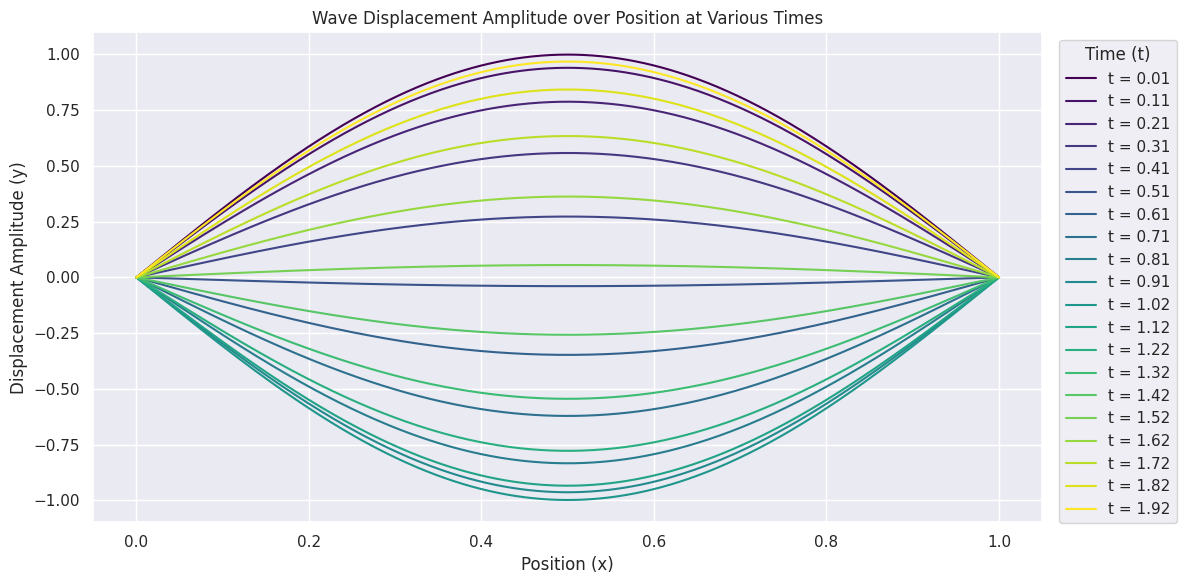

### Physics loss

In [ ]:
def physics_wave_loss(model: torch.nn.Module):
    ts = torch.linspace(0, L, steps = 500,).view(-1,1).requires_grad_(True).to(DEVICE)
    x = torch.linspace(0, 2, steps=500,).view(-1,1).requires_grad_(True).to(DEVICE)
    z = torch.cat([x,ts.reshape(-1,1)], axis=1)
    y = model(z)
    dT = grad(y, ts)[0]
    dX = grad(y, x)[0]
    dT2 = grad(dT, ts)[0]
    dX2 = grad(dX, x)[0]
    pde = dT2 - c**2*dX2

    return torch.mean(pde**2)

### Architecture experiments

In this set of experiments, various network architectures were tested for training both Vanilla Neural Networks and PINNs. For the width experiments, the number of hidden nodes per layer was varied among 32, 64, 100, 128, and 256. For the depth experiments, networks with 1, 5, 10, and 20 hidden layers were evaluated. The code and results for the best-performing configurations are provided below.

#### Width experiments: Vanilla Neural Network

In [ ]:
net_vanilla = Net(2,1, loss2=None, epochs=20000, lr=1e-6, n_units=256).to(DEVICE)

filepath = 'net_vanilla_256.pth'
losses = net_vanilla.fit(train_data, Y_train.flatten())
torch.save(net_vanilla, filepath)
plt.plot(losses)
plt.yscale('log')
plt.savefig('vanilla_loss_net_256.png')

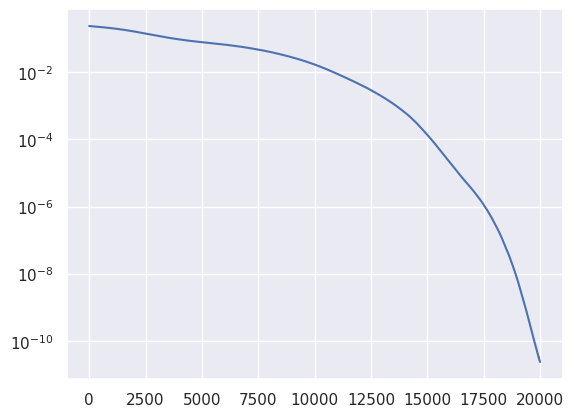

In [ ]:
net_vanilla = torch.load('net_vanilla_256.pth')
preds = net_vanilla.predict(test_data)
preds_2d = preds.reshape(-1,500)
# Plotting
plt.figure(figsize=(12, 6))
plt.contourf(X, T, preds_2d, 50, cmap='viridis')  # Heatmap of the wave amplitude
plt.colorbar(label="Displacement Amplitude (y)")
plt.xlabel("Position (x)")
plt.ylabel("Time (t)")
plt.title(f"Heatmap of Standing Wave on a String with Closed Boundaries (Mode {n})")

plt.scatter(X_train, T_train, c=Y_train, cmap='viridis', edgecolor='white', s=100, marker='*')

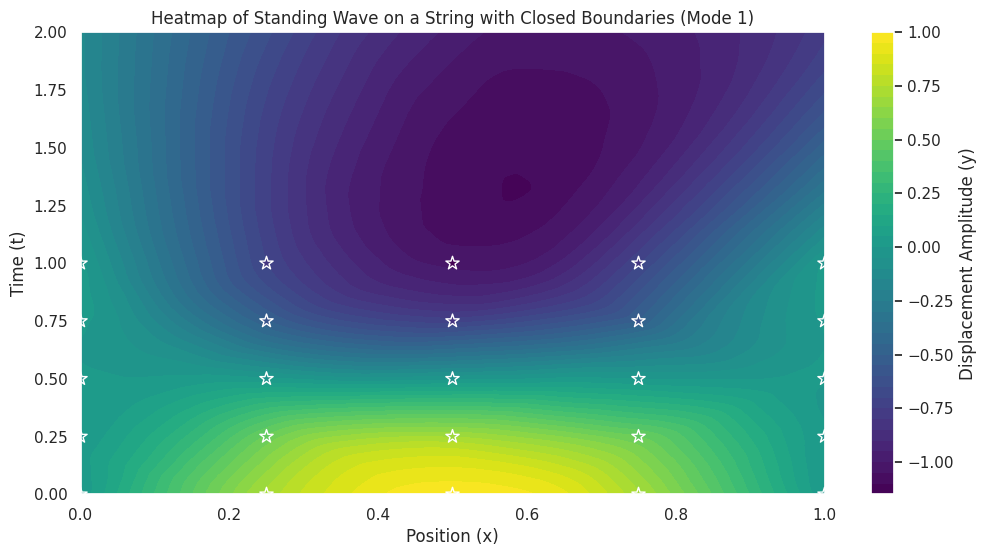

In [ ]:
# Plot
plt.figure(figsize=(12, 6))

# Plot amplitude vs position for a few time points
for i, (time_idx, color) in enumerate(zip(range(1, len(t), 10), colors)):  # Adjust step size to control the number of curves
    plt.plot(x, preds_2d[time_idx, :], color=color, label=f"t = {t[time_idx]:.2f}")

plt.xlabel("Position (x)")
plt.ylabel("Displacement Amplitude (y)")
plt.title("Wave Displacement Amplitude over Position at Various Times")
plt.legend(title="Time (t)", loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

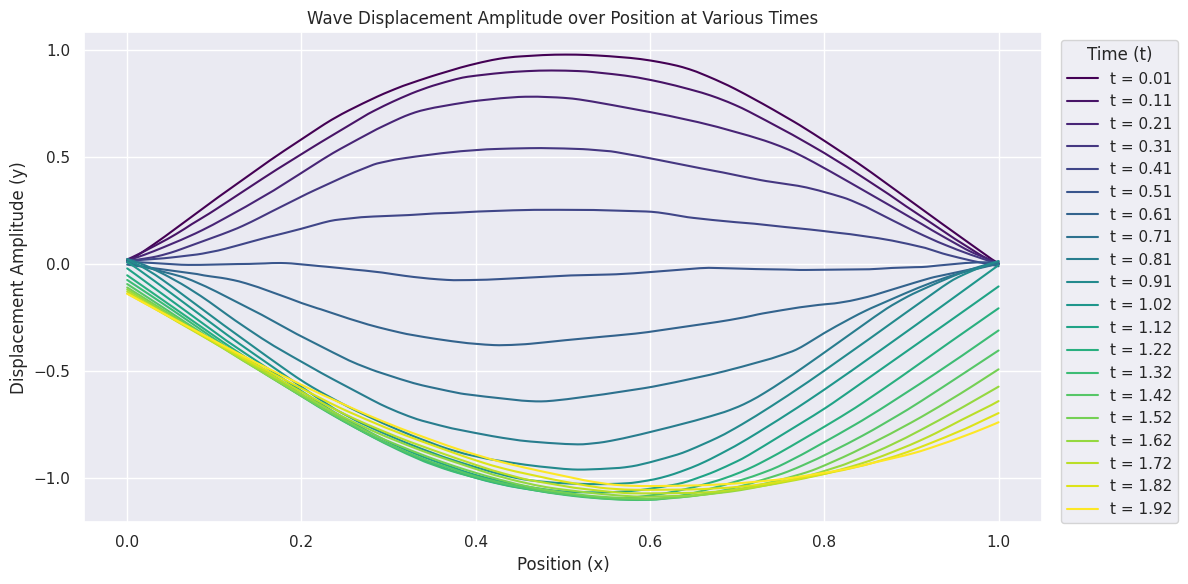

#### Width experiments: PINNs

In [ ]:
net = Net(2,1, loss2=physics_wave_loss, epochs=20000, loss2_weight=1, lr=1e-6, n_units = 256).to(DEVICE)
filepath = '/content/models/pinn_256.pth'
losses = net.fit(train_data, Y_train.flatten())
torch.save(net, filepath)
plt.plot(losses)
plt.yscale('log')
plt.savefig('pinn_loss_256.png')

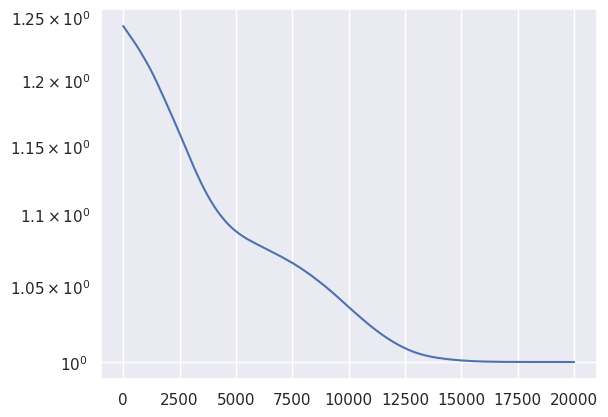

In [ ]:
net = torch.load('pinn_256.pth')
preds = net.predict(test_data)
preds_2d = preds.reshape(-1,500)
# Plotting
plt.figure(figsize=(12, 6))
plt.contourf(X, T, preds_2d, 50, cmap='viridis')  # Heatmap of the wave amplitude
plt.colorbar(label="Displacement Amplitude (y)")
plt.xlabel("Position (x)")
plt.ylabel("Time (t)")
plt.title(f"Heatmap of Standing Wave on a String with Closed Boundaries (Mode {n})")

plt.scatter(X_train, T_train, c=Y_train, cmap='viridis', edgecolor='white', s=100, marker='*')

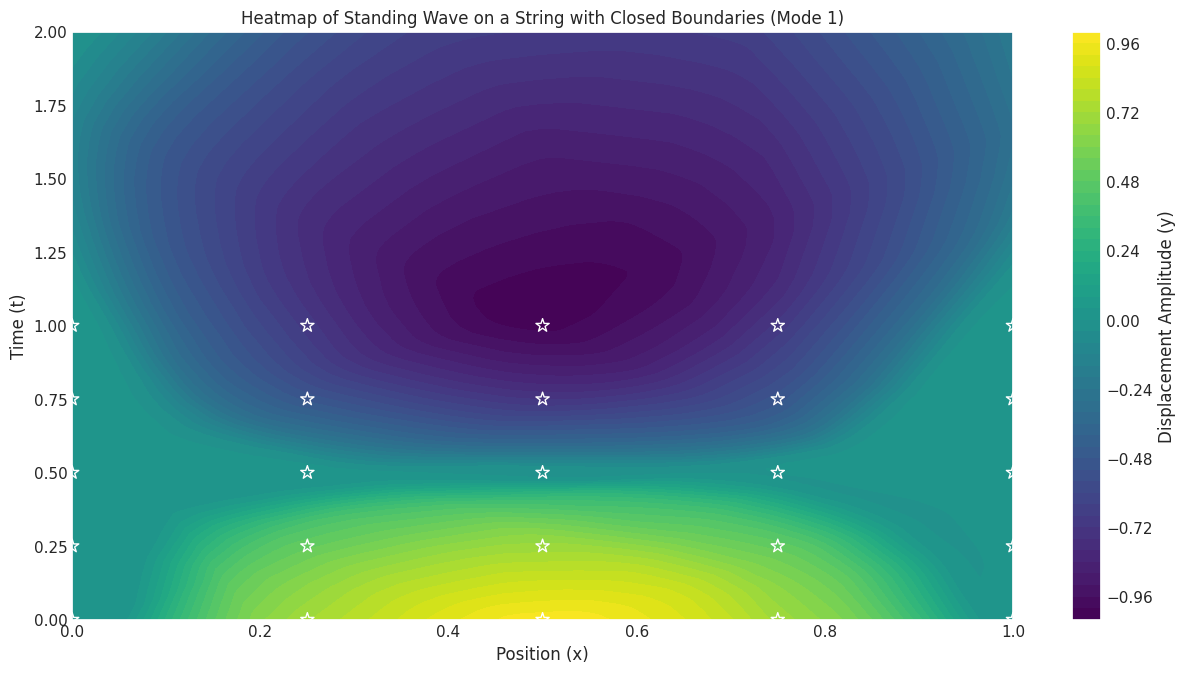

In [ ]:
# Plot
plt.figure(figsize=(12, 6))

# Plot amplitude vs position for a few time points
for i, (time_idx, color) in enumerate(zip(range(1, len(t), 10), colors)):  # Adjust step size to control the number of curves
    plt.plot(x, preds_2d[time_idx, :], color=color, label=f"t = {t[time_idx]:.2f}")

plt.xlabel("Position (x)")
plt.ylabel("Displacement Amplitude (y)")
plt.title("Wave Displacement Amplitude over Position at Various Times")
plt.legend(title="Time (t)", loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

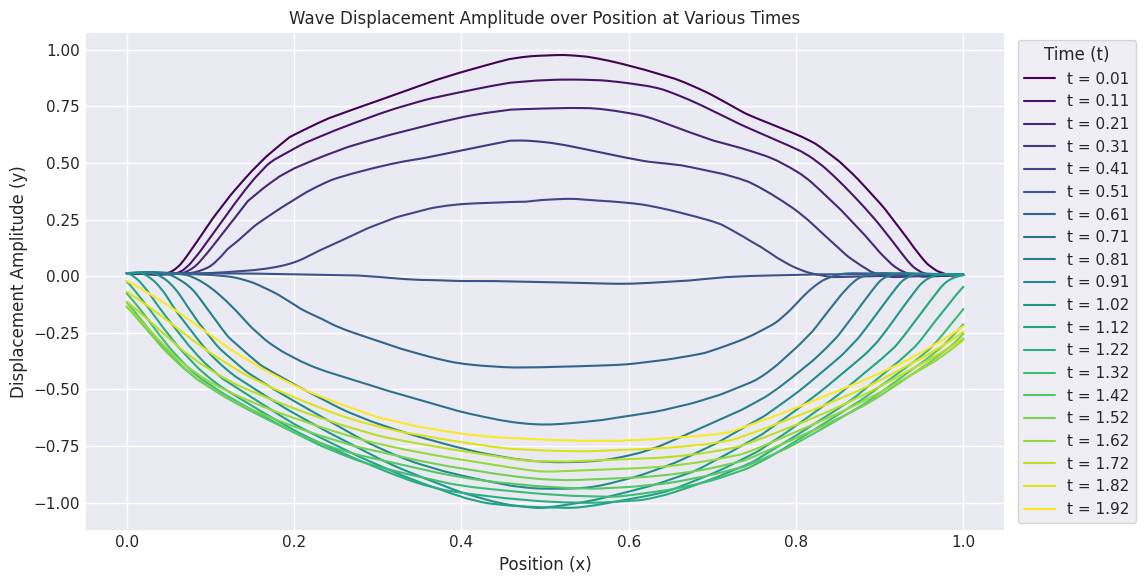

#### Depth experiments: Vanilla Neural Network

In [ ]:
net_vanilla = Net(2,1, loss2=None, epochs=20000, lr=1e-5, n_hidden_layers = 1, n_units = 64).to(DEVICE)

# print(train_data.shape)
# print(train_Y.shape)
filepath = '/content/vanilla_1layers.pth'
losses = net_vanilla.fit(train_data, Y_train.flatten())
torch.save(net_vanilla, filepath)
plt.plot(losses)
plt.yscale('log')
plt.savefig('vanilla_1layers.png')

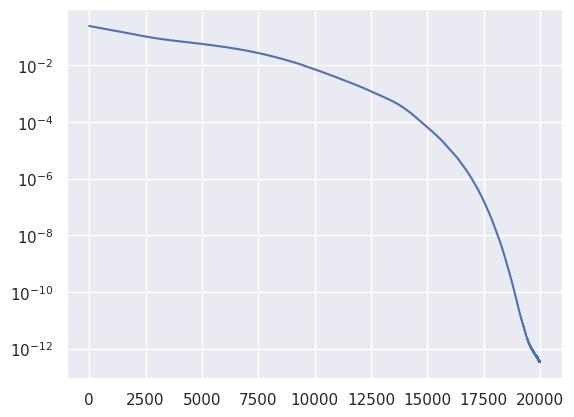

Below visualizations produced by the same code provided in subsections for width experiments.

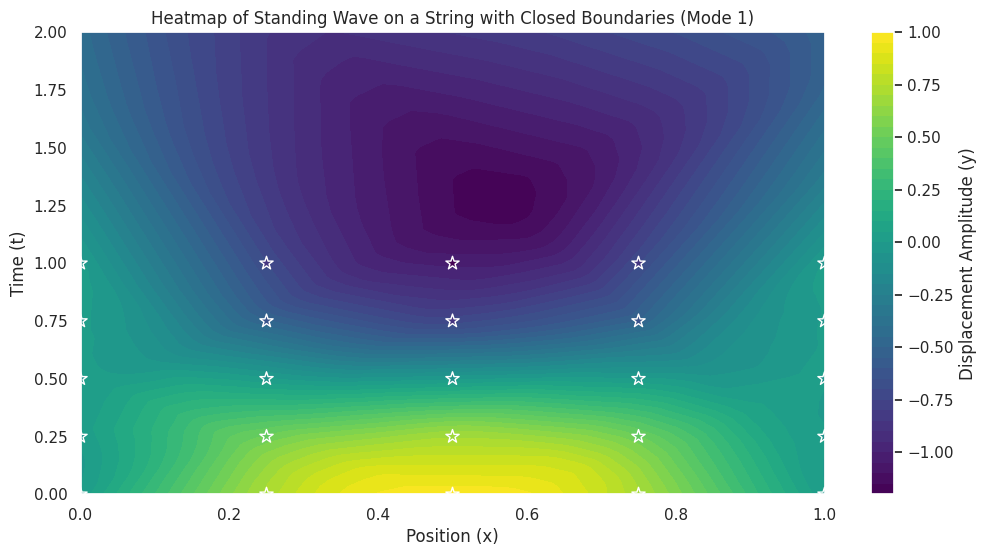

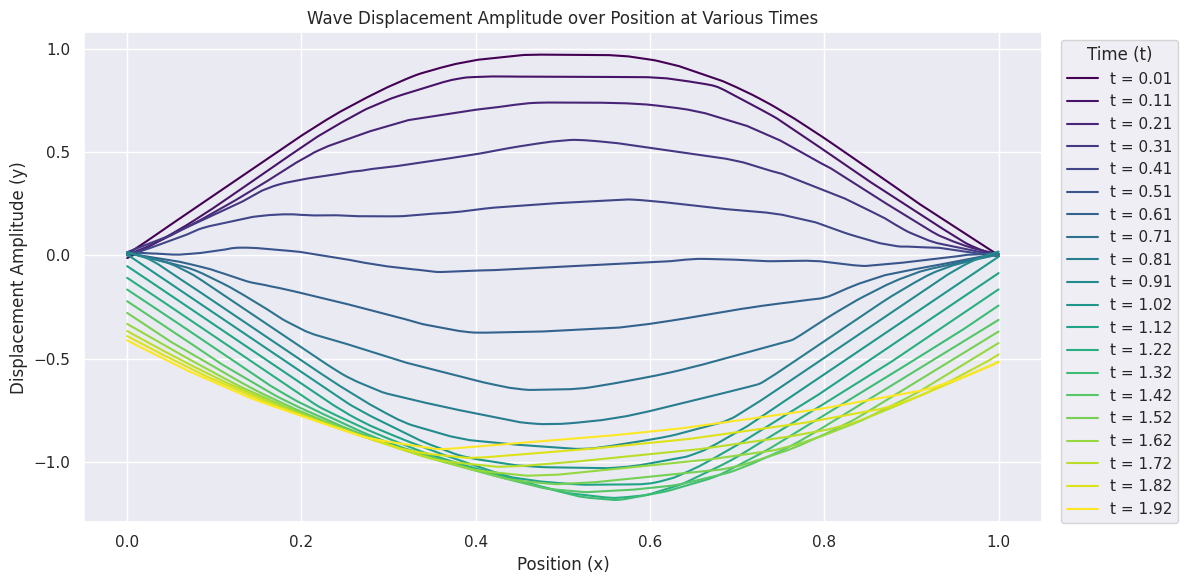

#### Depth experiments: PINNs

In [ ]:
net = Net(2,1, loss2=physics_wave_loss, epochs=20000, loss2_weight=1, lr=1e-6, n_units = 256, n_hidden_layers = 5).to(DEVICE)

# print(train_data.shape)
# print(train_Y.shape)
filepath = '/content/pinn_5layers.pth'
losses = net.fit(train_data, Y_train.flatten())
torch.save(net, filepath)
plt.plot(losses)
plt.yscale('log')
plt.savefig('pinn_5layers.png')

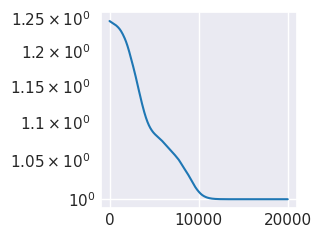

Below visualizations produced by the same code provided in subsections for width experiments.

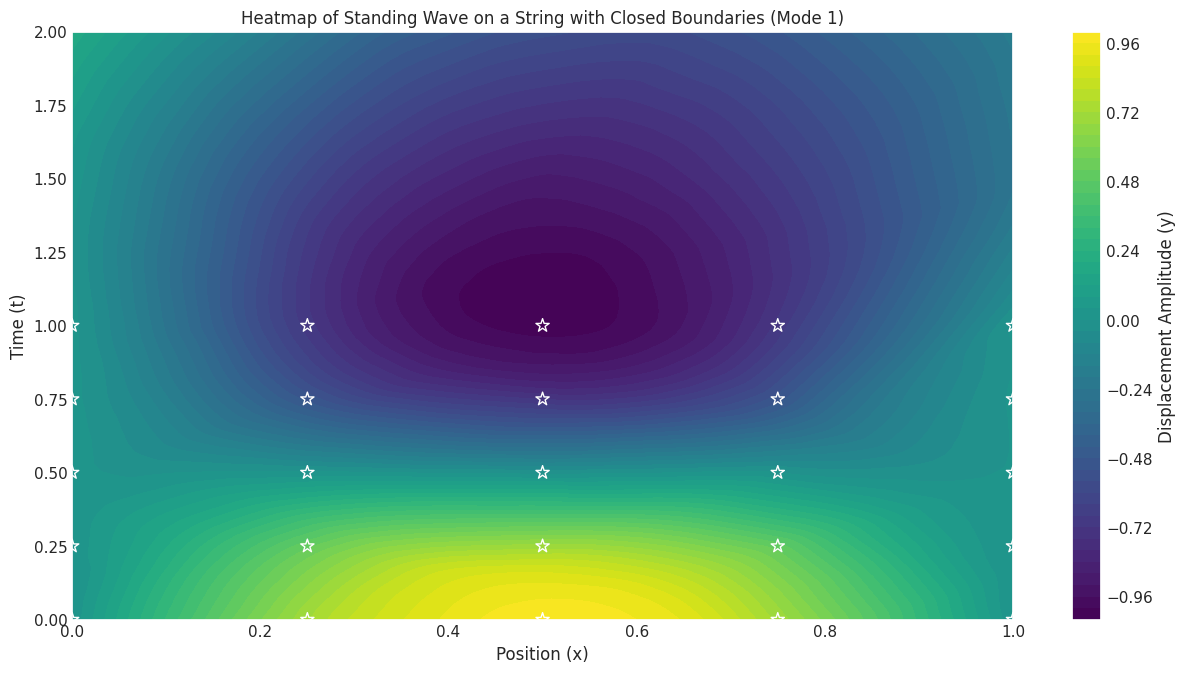

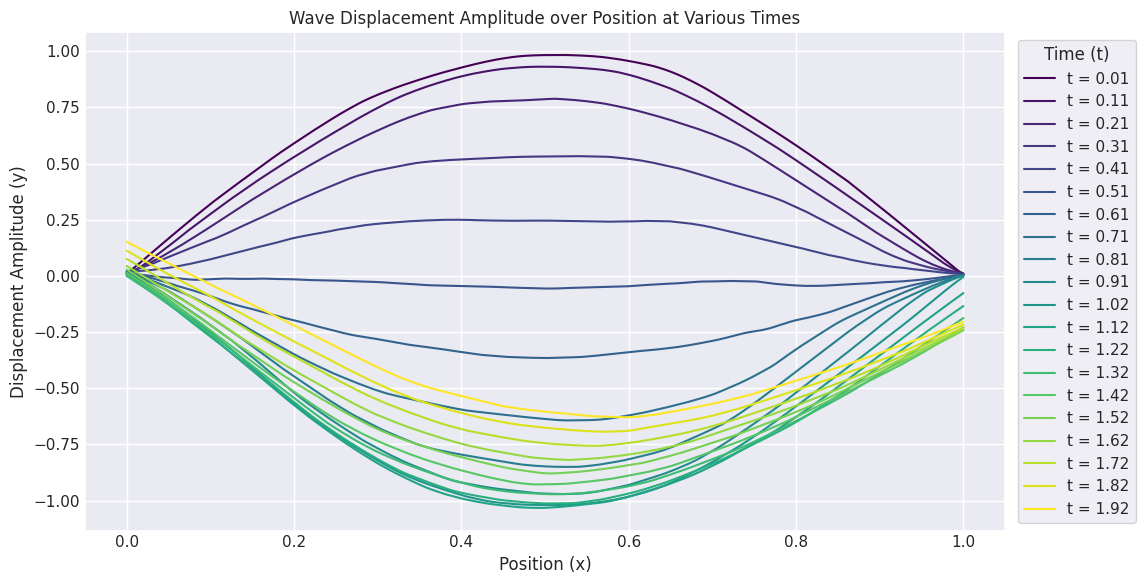

#### Collab notebook

[Architecture experiments](https://colab.research.google.com/drive/1GdpvdVfx5ltD_AzIlWikP4naKUHcBPxH?usp=sharing)

### Solving combined wave equation

In this experiment, two simple harmonic waves with mode = 1 and mode = 2 were generated and combined into a single wave, which was then used as input for a neural network to find the solution.

#### Data generation and visualization

In [ ]:
# Wave example

import numpy as np
import functools

# Parameters
A = 1.0           # Amplitude
L = 1.0           # Length of the string
c = 1.0           # Wave speed
n = 1             # Mode number (fundamental frequency)
phi = 0           # Phase shift
omega_1 = n * np.pi * c / L           # Angular frequency
k_1 = n * np.pi / L  # wave number

omega_2 = 2 * np.pi * c / L           # Angular frequency
k_2 = 2 * np.pi / L  # wave number
# Use functools.partial to fix all parameters except for time and position
wave_function_1 = functools.partial(harmonic_wave, A=A, k=k_1, w=omega_1, phi=phi)
wave_function_2 = functools.partial(harmonic_wave, A=A, k=k_2, w=omega_2, phi=phi)
# Define x and t ranges
x = np.linspace(0, L, 500)          # Position array
t = np.linspace(0, 2, 200)          # Time array

# Evaluate the harmonic wave
X, T = np.meshgrid(x, t)
Y = wave_function_1(X, T) + wave_function_2(X,T)

test_data = np.stack([X.flatten(), T.flatten()], axis=-1)

# Make training data
np.random.seed(10)
# Overlaying sample points on the heatmap
x_train = np.linspace(0, L, 5)            # Sample x points
t_train = np.linspace(0, 1, 5)            # Sample t points
X_train, T_train = np.meshgrid(x_train, t_train)
Y_train = wave_function_1(X_train,T_train) + wave_function_2(X_train,T_train) + 0.01 * np.random.randn(5)

train_data = np.stack([X_train.flatten(), T_train.flatten()], axis=-1)

# Plotting
plt.figure(figsize=(12, 6))
plt.contourf(X, T, Y, 50, cmap='viridis')  # Heatmap of the wave amplitude
plt.colorbar(label="Displacement Amplitude (y)")
plt.xlabel("Position (x)")
plt.ylabel("Time (t)")
plt.title(f"Heatmap of Standing Wave on a String with Closed Boundaries (Mode {n})")


# Overlay points as stars or dots
plt.scatter(X_train, T_train, c=Y_train, cmap='viridis', edgecolor='white', s=100, marker='*')

plt.show()


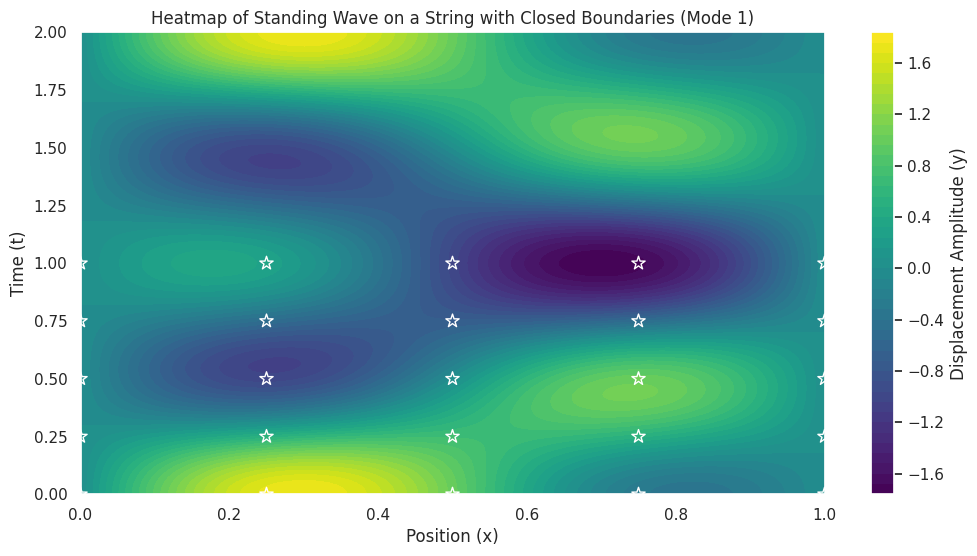

In [ ]:
# Plot
plt.figure(figsize=(12, 6))

# Use a colormap
cmap = plt.get_cmap("viridis")  # Choose a colormap (e.g., "viridis", "plasma", "cool", etc.)
colors = cmap(np.linspace(0, 1, len(range(1, len(t), 10))))  # Generate a color for each line

# Plot amplitude vs position for a few time points
for i, (time_idx, color) in enumerate(zip(range(1, len(t), 10), colors)):  # Adjust step size to control the number of curves
    plt.plot(x, Y[time_idx, :], color=color, label=f"t = {t[time_idx]:.2f}")

plt.xlabel("Position (x)")
plt.ylabel("Displacement Amplitude (y)")
plt.title("Wave Displacement Amplitude over Position at Various Times")
plt.legend(title="Time (t)", loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

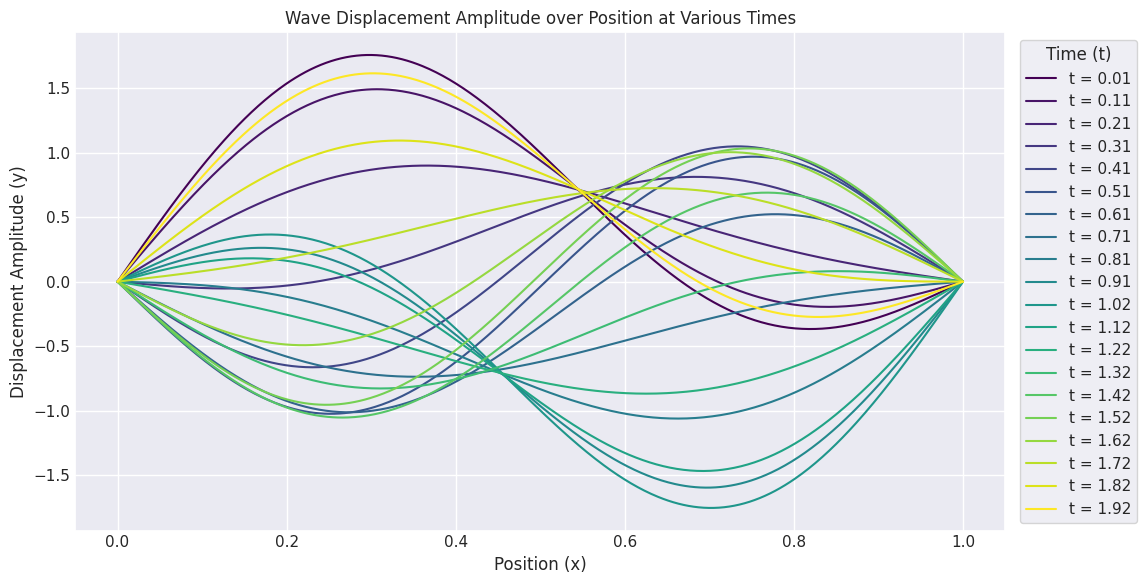

#### Vanilla Neural Network Training and Results Visualization

In [ ]:
net_vanilla = Net(2,1, loss2=None, epochs=22000, lr=1e-6, n_units=256).to(DEVICE)


filepath = '/content/models/new_wave_net_vanilla.pth'
losses = net_vanilla.fit(train_data, Y_train.flatten())
torch.save(net_vanilla, filepath)
plt.plot(losses)
plt.yscale('log')
plt.savefig('new_wave_vanilla_net.png')

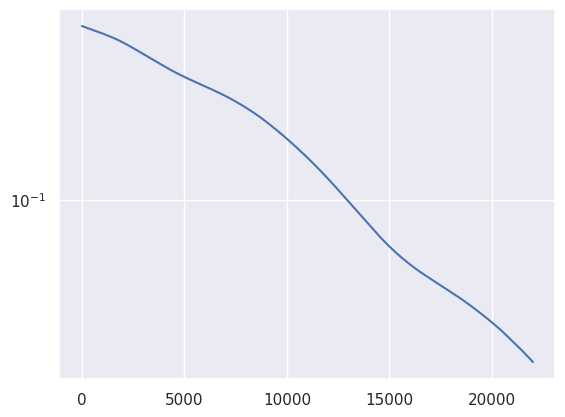

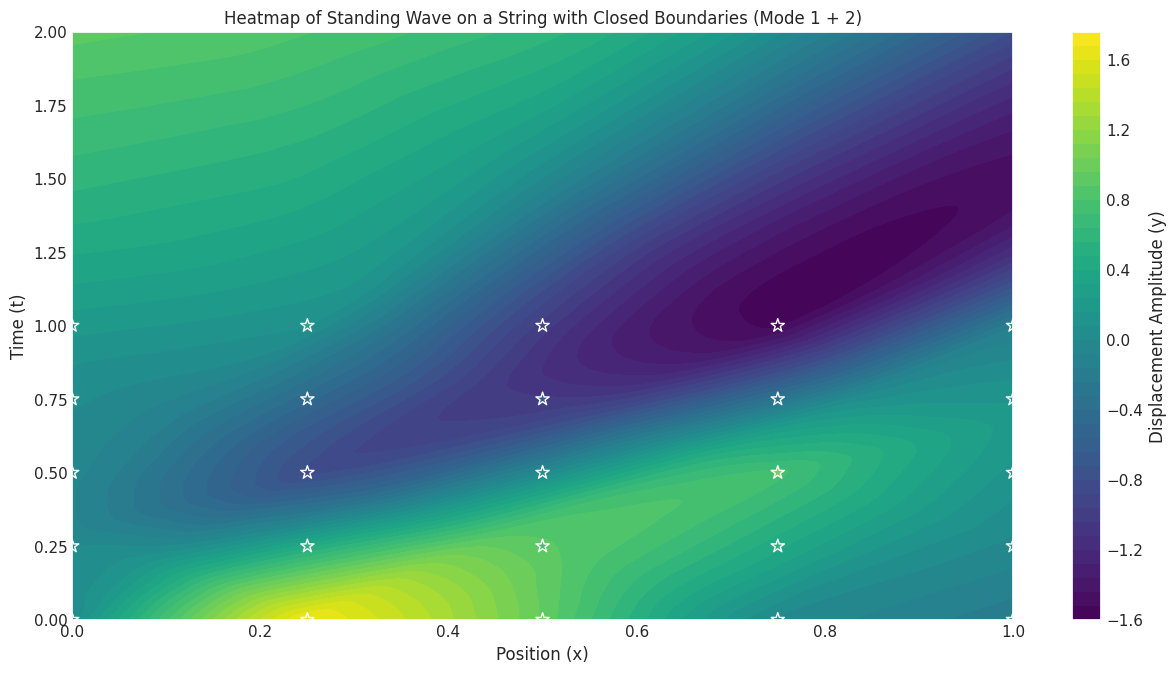

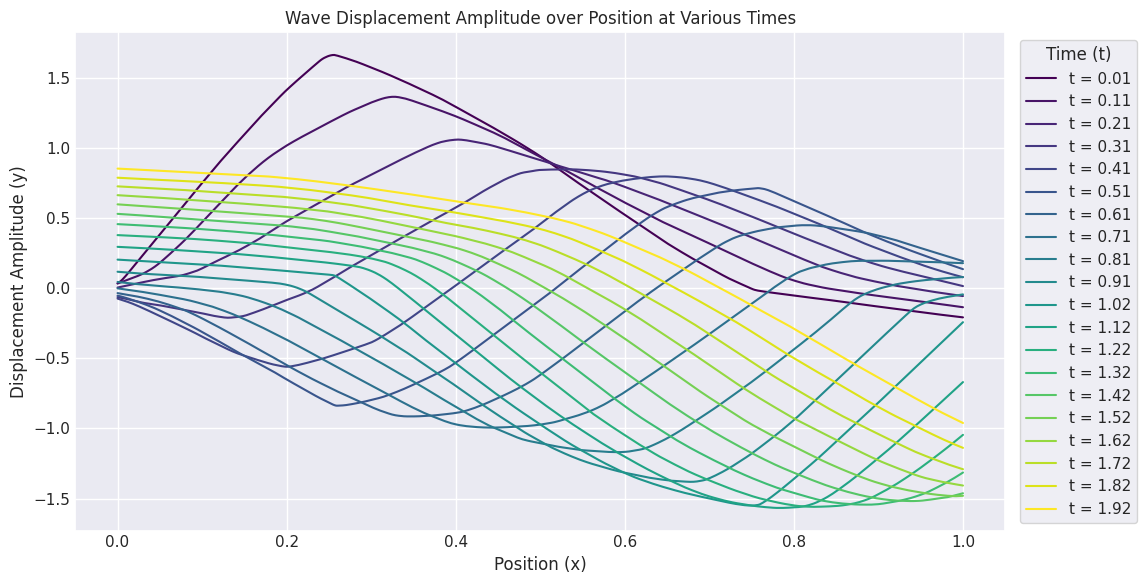

#### PINNs Training and Results Visualization

In [ ]:
# n_units = 100
net = Net(2,1, loss2=physics_wave_loss, epochs=22000, loss2_weight=1, lr=1e-6, n_units = 256, n_hidden_layers = 5).to(DEVICE)
filepath = 'new_wave_pinn.pth'
losses = net.fit(train_data, Y_train.flatten())
torch.save(net, filepath)
plt.plot(losses)
plt.yscale('log')
plt.savefig('new_wave_pinn_loss.png')

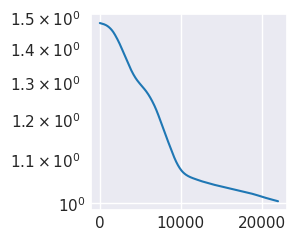

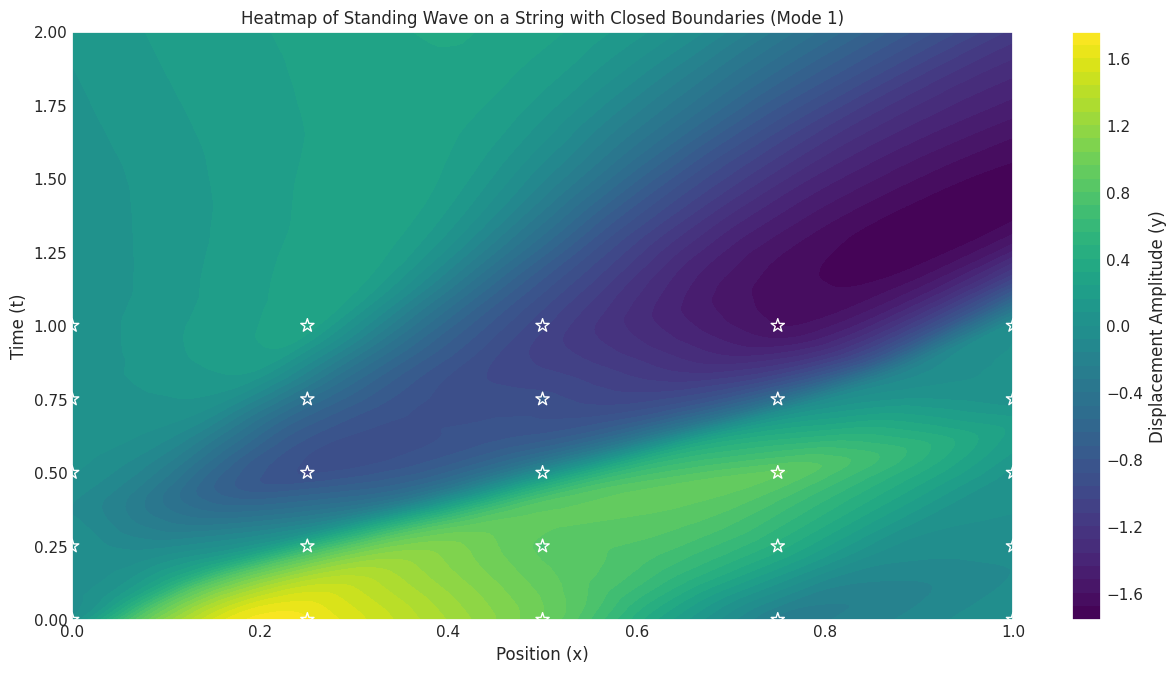

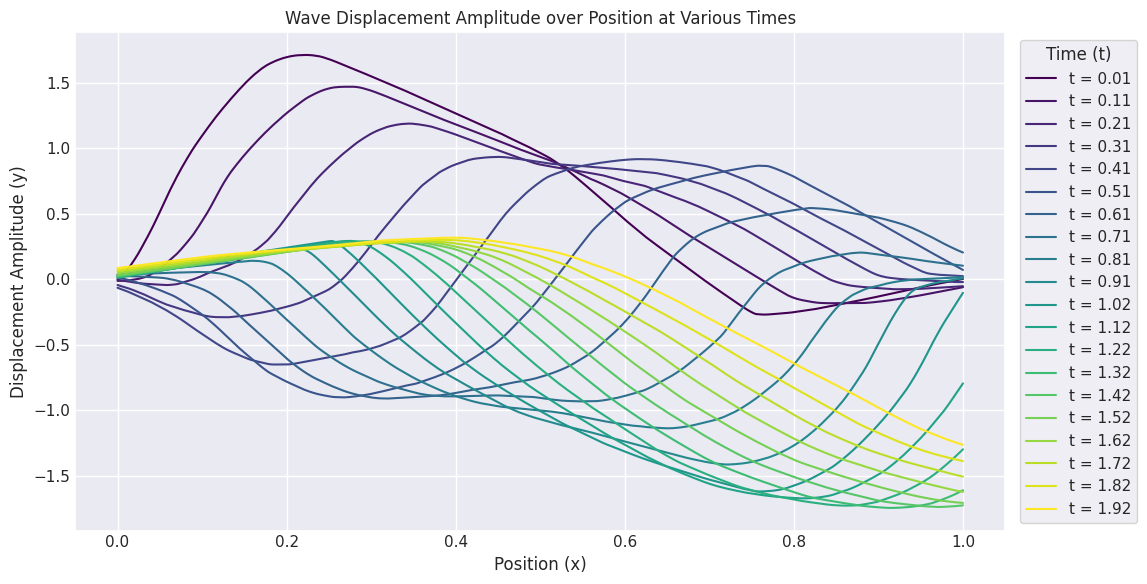

To improve prediction performance, the training dataset size was scaled up by 20x. The resulting predictions are as follows: the first results corresponds to the Vanilla Neural Network, while the second was generated using PINNs.

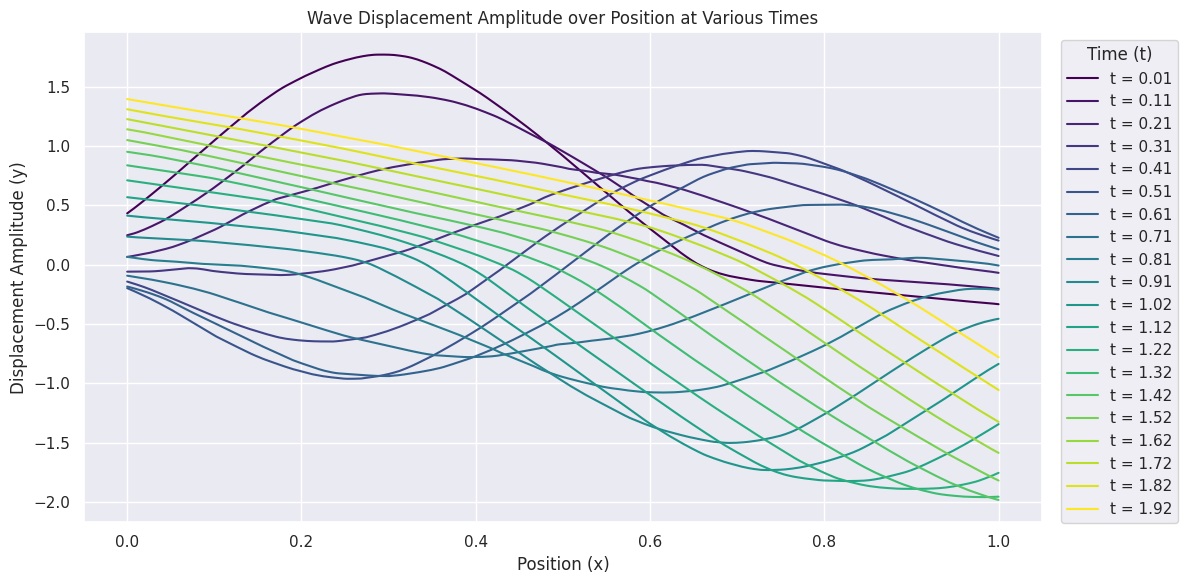 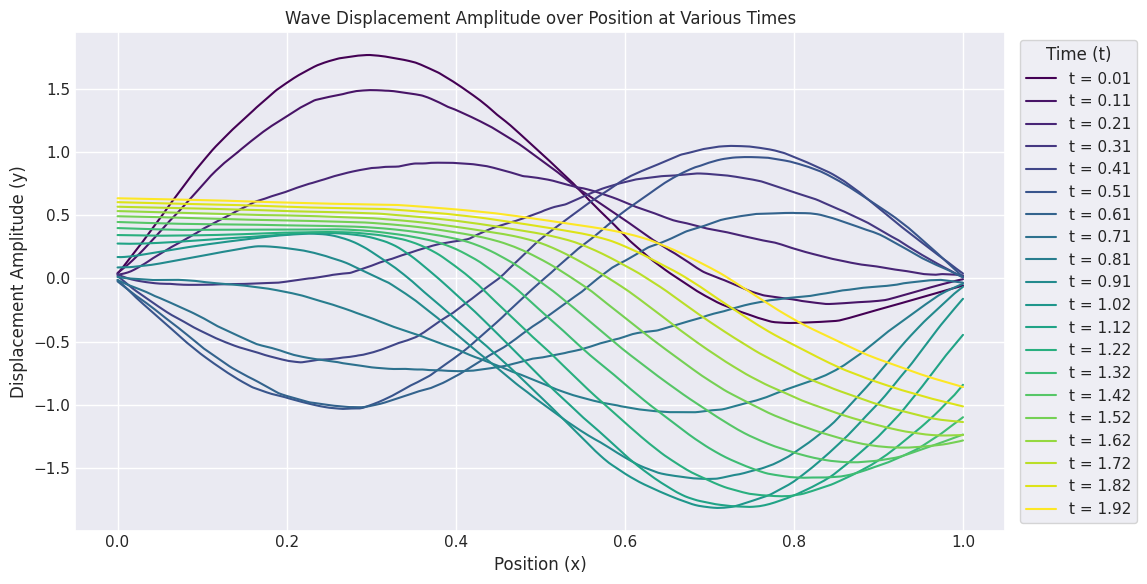

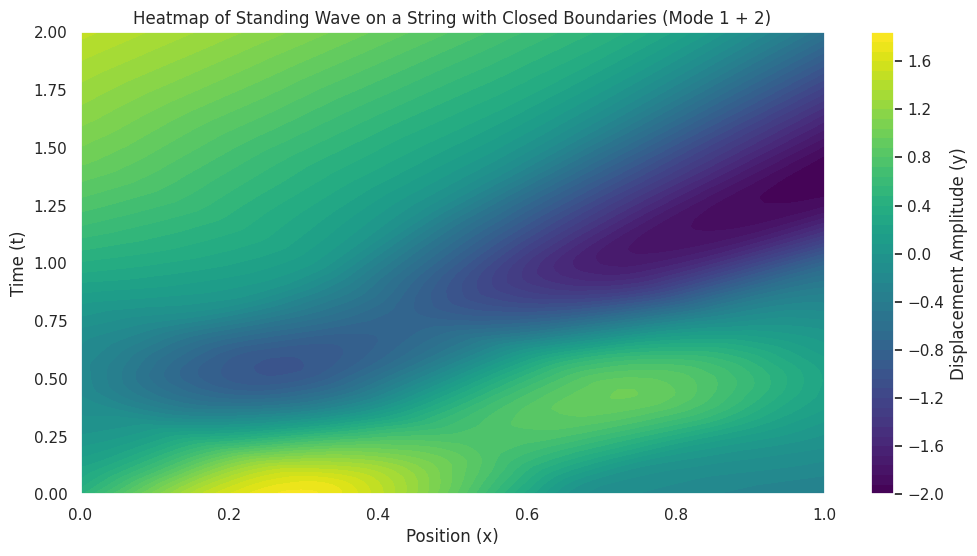
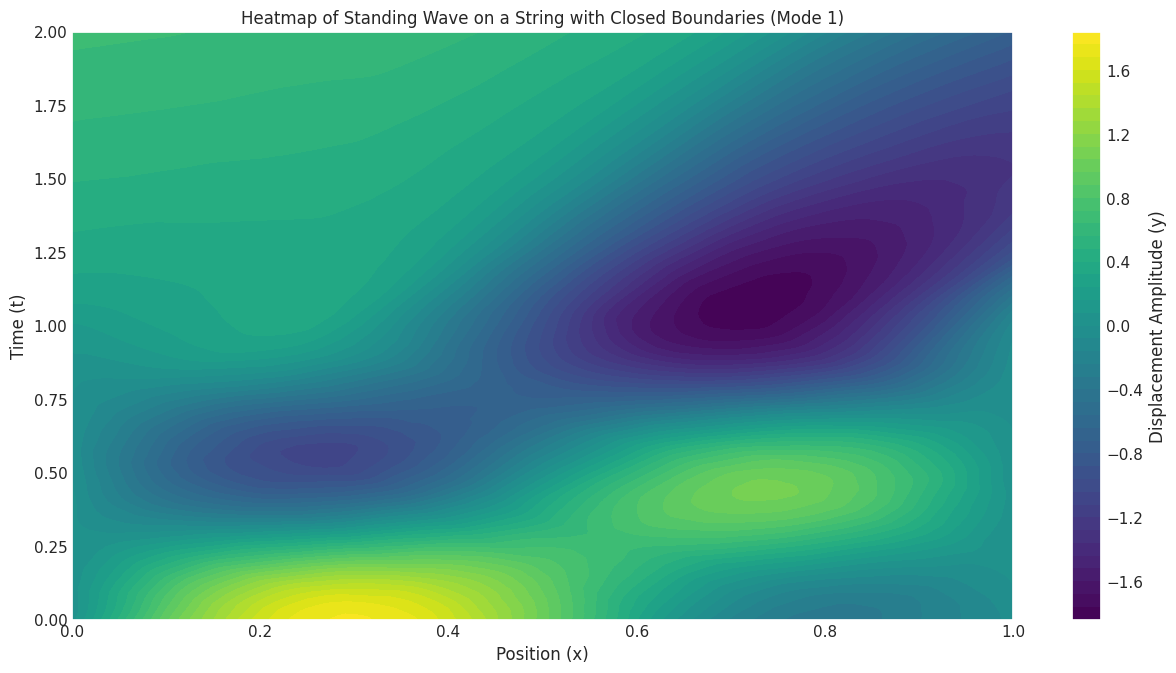

#### Collab notebook

[Combined wave equation](https://colab.research.google.com/drive/1X3tLEpkHWTHl7VojYcLlkWrbabvFQBz3?usp=sharing)

## 5. Discussions

This section provides a detailed analysis of the results obtained in the previous three sections.

In the first set of experiments on heat distribution, PINNs demonstrated their effectiveness in solving the one-dimensional heat equation, especially when provided with a limited number of training data points. In contrast, the vanilla neural network struggled to achieve comparable performance.

In the second set of experiments, where PINNs were applied to solve the two-dimensional Schrödinger equation, it was observed that increasing the number of training epochs improved performance.  Since training the model on Google Colab was time-consuming, UTRGV’s Cradle cluster was utilized to expedite the process. With this setup, training for 50,000 epochs was completed in under five minutes, which suggests that utilizing GPU for traning PINNs is beneficial to shorten training time. However, this improvement primarily led to accurate predictions along the boundaries of the wave, while the intermediate regions were poorly predicted.

The third set of experiments focused on predictions of wave equations using different network architectures. It was found that increasing the number of nodes in each hidden layer improved the predictions of PINNs. However, adding more hidden layers did not enhance their performance. When comparing PINNs to vanilla neural networks, PINNs were better at capturing the shape of the wave.

Finally, when the wave equation was made more complex by combining two harmonic waves, both vanilla neural networks and PINNs struggled to make accurate predictions. In order to improve predictions training data sample was increased up to 20 times, as a result it was seen that PINN and vanilla neural network's predictions were improved and PINN's predictions resembled the original wave equations.  This suggests that with better parameter optimization, PINNs could potentially achieve better perfomance. Exploring these optimization techniques is left for future work.

## 6. Conclusion

This report demonstrates the potential of PINNs as powerful tools for solving diverse physical problems by incorporating prior knowledge of physical laws into the learning process. Through the experiments conducted on the heat equation, Schrödinger equation, and wave equation, several key insights were gained:
1.	Effectiveness with Limited Data: PINNs excel in scenarios with sparse
training data, outperforming vanilla neural networks in accurately approximating solutions governed by physical laws.
2.	Impact of Training and Computational Resources: Increasing the number of training epochs and leveraging GPU resources significantly improves PINN performance, particularly along boundary regions. This highlights the importance of efficient computational setups in PINN training.
3.	Architecture Optimization: While increasing the number of nodes in hidden layers enhances prediction accuracy, adding more layers does not necessarily yield better results. This underscores the need for careful network design tailored to the problem at hand.
4.	Challenges with Complex Systems: Both PINNs and vanilla neural networks struggled with more complex wave equations. However, increasing the training data size significantly improved PINN predictions, suggesting that parameter optimization techniques, could further enhance their performance.

In summary, PINNs provide a robust framework for integrating physics-based priors into machine learning models, enabling accurate and interpretable solutions to complex problems. However, challenges such as optimizing network architectures, improving intermediate region predictions, and handling highly complex systems remain areas for future exploration. Addressing these challenges will further unlock the potential of PINNs in physics, engineering, and beyond.

## 7. References

1. Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations. Maziar Raissi, Paris Perdikaris, George Em Karniadakis, 2017. https://arxiv.org/abs/1711.10561.
2. PINNs-TF2: Fast and User-Friendly Physics-Informed Neural Networks in TensorFlow V2. Reza Akbarian Bafghi and Maziar Raissi, 2023. https://arxiv.org/abs/2311.03626.
3. https://medium.com/@theo.wolf/physics-informed-neural-networks-a-simple-tutorial-with-pytorch-f28a890b874a
4. https://github.com/rezaakb/pinns-torch/blob/main/tutorials/0-Schrodinger.ipynb